In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks

from advopt.classifier import *
from advopt.target.utils import combine
from advopt.target import logloss

/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
task = tasks.XOR()
assert len(task.search_space()) == 1, 'This example only works for 1D search space.'

params = np.linspace(task.search_space()[0][0], task.search_space()[0][1], num=51)

clf_type = 'GBDT'
size = 32 * 1024

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

n_trees = 20
n_control = 5

depth = 3

clfs = dict()

for i in range(n_control):
    clfs['JSD_%d' % (i + 1, )] = GradientBoostingClassifier(n_estimators=(i + 1) * n_trees, max_depth=depth)

clfs['log-pJSD'] = AdaptiveBoosting(
    GradientBoostingClassifier(n_estimators=n_control * n_trees, max_depth=depth),
    thresholds=logspace(n_control * n_trees)
)

clfs['lin-pJSD'] = AdaptiveBoosting(
    GradientBoostingClassifier(n_estimators=n_control * n_trees, max_depth=depth),
    thresholds=linspace(n_control * n_trees)
)

In [4]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

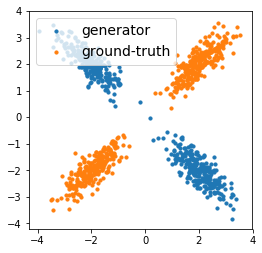

In [5]:
try:
    d_pos = task.ground_truth_generator()(size)
    d_neg = task.generator(task.example_parameters())(size)
    
    plt.figure(figsize=(4, 4))
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.legend(loc='upper left', fontsize=14)
    plt.savefig('%s-example.pdf' % (task.name(), ))
except:
    pass

In [6]:
divergences = {
    name : np.zeros(shape=(params.shape[0], ))
    for name in clfs
}

for i, param in enumerate(tqdm(params)):
    if task.is_synthetic():
        data_neg = task.transform(data_neg_0, [param])
        data_neg_test = task.transform(data_neg_test_0, [param])
    else:
        data_neg = task.generator([param])(size)
        data_neg_test = task.generator([param])(size)
        
    data, labels = combine(data_pos, data_neg)
    data_test, labels_test = combine(data_pos_test, data_neg_test)
    
    for name in clfs:
        clf = clfs[name]
        clf.fit(data, labels)
        proba = clf.predict_proba(data_test)
        
        divergences[name][i] = np.log(2) - np.mean(
            logloss(labels_test, proba[:, 1])
        )

In [7]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'wb') as f:
    pickle.dump(divergences, f)

In [8]:
import pickle
with open('pJSD-%s-%s.pickled' % (task.name(), clf_type), 'rb') as f:
    divergences = pickle.load(f)

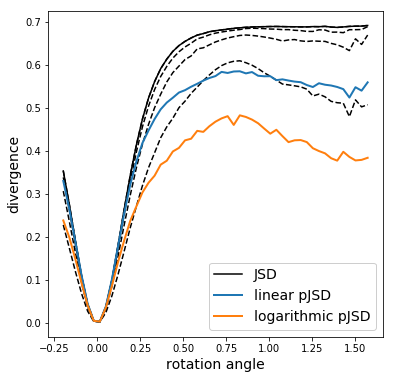

In [9]:
plt.figure(figsize=(6, 6))
for i in range(n_control - 1):
    plt.plot(params, divergences['JSD_%d' % (i + 1, )], '--', color='black')

plt.plot(params, divergences['JSD_%d' % (n_control - 1, )], '-', color='black', label='JSD')

plt.plot(params, divergences['lin-pJSD'], lw=2, label='linear pJSD', color=plt.cm.tab10(0))
plt.plot(params, divergences['log-pJSD'], lw=2, label='logarithmic pJSD', color=plt.cm.tab10(1))
    
plt.legend(loc='lower right', fontsize=14, framealpha=0.95)
plt.xlabel(task.parameters_names()[0], fontsize=14)
plt.ylabel('divergence', fontsize=14)

plt.savefig('%s-%s.pdf' % (task.name(), clf_type))